In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import time

from ipynb.fs.full.OnlineStatistics import OnlineStatistics
from ipynb.fs.full.PCA import reconstruct_pca
from ipynb.fs.full.PCA import reconstruct_pca_with_online_stat
from ipynb.fs.full.IncrementalPCA import reconstruct_incremental_pca
from ipynb.fs.full.SPIRIT import SPIRIT

from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import mean_squared_error

import logging
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [2]:
def generate_random_data(nobjects=10, ndim=3):
    np.random.seed(1)
    rng = np.random.RandomState(1999)
    A = rng.randn(nobjects, ndim) + 2
    return A

In [3]:
def build_estimation_func_dictionary(dataset, nobjects, ndims, 
                                     mse_pca, mse_pca_online, mse_inc_pca, mse_spirit,
                                     time_pca, time_pca_online, time_inc_pca, time_spirit):
    results = {}
    results['dataset'] = dataset
    results['total_data'] = nobjects
    results['dimension'] = ndims
    results['mse_pca'] = mse_pca
    results['mse_pca_online'] = mse_pca_online
    results['mse_inc_pca'] = mse_inc_pca
    results['mse_spirit'] = mse_spirit
    results['time_pca'] = time_pca
    results['time_pca_online'] = time_pca_online
    results['time_inc_pca'] = time_inc_pca
    results['time_spirit'] = time_spirit
    return results

In [4]:
def run_spirit(A):
    # initialize SPIRIT parameters
    W = np.identity(A.shape[1])
    k = 1
    E = 0
    E_est = 0
    t = 1
    d = 0.01 * np.ones(A.shape[1])
    fE = 0.95
    FE = 0.98
    lamda = 1
    A_spirit = None
    start = time.perf_counter()
    for i in range(len(A)):
        xt = A[i,:]
        W, d, k, xt_estimate = SPIRIT(xt, t, E, E_est, W, d, k, lamda, fE, FE)
        if A_spirit is None:
            A_spirit = xt_estimate
        else:
            A_spirit = np.vstack((A_spirit, xt_estimate))
    total_time_spirit = time.perf_counter() - start
    mse_spirit = mean_squared_error(A, A_spirit)
    return total_time_spirit, mse_spirit

In [5]:
def run_pca(A, variance_explained=0.9025):
    A_pca, time_pca= reconstruct_pca(A, variance_explained, profiling=True)
    mse_pca = mean_squared_error(A, A_pca)
    return time_pca, mse_pca

In [6]:
def run_pca_with_online_stat(A, variance_explained=0.9025):
    A_pca_online, time_pca_online= reconstruct_pca_with_online_stat(A, variance_explained, profiling=True)
    mse_pca_online = mean_squared_error(A, A_pca_online)
    return time_pca_online, mse_pca_online

In [7]:
def run_incremental_pca(A, variance_explained=0.9025):
    init_time = time.perf_counter()
    inc_pca = IncrementalPCA()
    init_time_duration = time.perf_counter() - init_time
    A_inc_pca, time_inc_pca = reconstruct_incremental_pca(A, inc_pca, variance_explained, profiling=True)
    time_inc_pca += init_time_duration
    mse_inc_pca = mean_squared_error(A, A_inc_pca)
    return time_inc_pca, mse_inc_pca

In [22]:
def build_experiment_dataframe(filenames, time='miliseconds', variance_explained=0.9025):
    dataset = list ()
    nobjects = list ()
    ndims = list ()
    mse_pca = list ()
    mse_pca_online = list ()
    mse_inc_pca = list ()
    mse_spirit = list ()
    time_pca = list ()
    time_pca_online = list ()
    time_inc_pca = list ()
    time_spirit  = list ()
    
    if time=='miliseconds':
        multiplier = 1000
    
    for filename in filenames:
        logging.info(f'Running {filename}')
        idx = filename.rfind('/')
        ds_name = filename[idx+1:].replace('.csv', '')
        dataset.append(ds_name)
        raw = pd.read_csv(filename)
        data = raw.drop(['label'], axis=1).values
        
        if 'covtype' in filename or 'kddcup1999' in filename:
            data = data[0:18000,:]
        
        nobjects.append(data.shape[0])
        ndims.append(data.shape[1])
        logging.info("PCA ...")
        t_pca, m_pca = run_pca(data, variance_explained)
        time_pca.append(t_pca * multiplier)
        mse_pca.append(m_pca)
        
        logging.info("PCA with online update on covariance matrix...")
        t_pca_online, m_pca_online = run_pca_with_online_stat(data, variance_explained)
        time_pca_online.append(t_pca_online * multiplier)
        mse_pca_online.append(m_pca_online)
        
        logging.info("Incremental PCA with SVD...")
        t_inc_pca, m_inc_pca = run_incremental_pca(data, variance_explained)
        time_inc_pca.append(t_inc_pca * multiplier)
        mse_inc_pca.append(m_inc_pca)
        
        logging.info("Spirit...")
        t_spirit, m_spirit = run_spirit(data)
        time_spirit.append(t_spirit * multiplier)
        mse_spirit.append(m_spirit)  
    
    results = {}
    results['dataset'] = dataset
    results['total_data'] = nobjects
    results['dimension'] = ndims
    results['mse_pca'] = mse_pca
    results['mse_pca_online'] = mse_pca_online
    results['mse_inc_pca'] = mse_inc_pca
    results['mse_spirit'] = mse_spirit
    results['time_pca'] = time_pca
    results['time_pca_online'] = time_pca_online
    results['time_inc_pca'] = time_inc_pca
    results['time_spirit'] = time_spirit
    
    return pd.DataFrame(results)

In [9]:
def build_experiment_synthetic_data(metadata, time='miliseconds', variance_explained=0.9025):
    dataset = list ()
    nobjects = list ()
    ndims = list ()
    mse_pca = list ()
    mse_pca_online = list ()
    mse_inc_pca = list ()
    mse_spirit = list ()
    time_pca = list ()
    time_pca_online = list ()
    time_inc_pca = list ()
    time_spirit  = list ()
    
    if time=='miliseconds':
        multiplier = 1000
    
    for info in metadata:
        logging.info(f'Running {info}')
        title = f'({info[0]}, {info[1]})'
        dataset.append(title)
        data = generate_random_data(nobjects=info[0], ndim=info[1])
        nobjects.append(data.shape[0])
        ndims.append(data.shape[1])
        
        logging.info("PCA ...")
        t_pca, m_pca = run_pca(data, variance_explained)
        time_pca.append(t_pca * multiplier)
        mse_pca.append(m_pca)
        
        logging.info("PCA with online update on covariance matrix...")
        t_pca_online, m_pca_online = run_pca_with_online_stat(data, variance_explained)
        time_pca_online.append(t_pca_online * multiplier)
        mse_pca_online.append(m_pca_online)
        
        logging.info("Incremental PCA with SVD...")
        t_inc_pca, m_inc_pca = run_incremental_pca(data, variance_explained)
        time_inc_pca.append(t_inc_pca * multiplier)
        mse_inc_pca.append(m_inc_pca)
        
#         logging.info("Spirit...")
#         t_spirit, m_spirit = run_spirit(data)
#         time_spirit.append(t_spirit * multiplier)
#         mse_spirit.append(m_spirit)  
        
    results = {}
#     results['dataset'] = dataset
    results['total_data'] = nobjects
    results['dimension'] = ndims
    results['mse_pca'] = mse_pca
    results['mse_pca_online'] = mse_pca_online
    results['mse_inc_pca'] = mse_inc_pca
#     results['mse_spirit'] = mse_spirit
    results['time_pca'] = time_pca
    results['time_pca_online'] = time_pca_online
    results['time_inc_pca'] = time_inc_pca
#     results['time_spirit'] = time_spirit
    return pd.DataFrame(results)

In [10]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 6)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
def draw_bar_chart(df, label, title, metric='mse', 
                   timeunit = None,
                   figwidth=8, figheight=6,  
                   colors=('#D81B60', '#047562', '#1E88E5'), 
                   hatch=('-', '\\', '/')):
    labels = df[label]
    
    pca = df[f'{metric}_pca'].round(2)
    pca_online = df[f'{metric}_pca_online'].round(2)
    inc_pca = df[f'{metric}_inc_pca'].round(2)
    
    fig, ax = plt.subplots(figsize=(figwidth * 2, figheight))

    # set width of bar
    barWidth = 0.25

    # Set position of bar on X axis
    r1 = np.arange(len(labels))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Make the plot
    rects1 = ax.bar(r1, pca,
                    color=colors[0],
                    width=barWidth, edgecolor='white',
                    label='PCA',
                    hatch=hatch[0])
    rects2 = ax.bar(r2, pca_online,
                    color=colors[1],
                    width=barWidth, edgecolor='white',
                    label='PCA Online',
                    hatch=hatch[1])
    rects3 = ax.bar(r3, inc_pca,
                    color=colors[2],
                    width=barWidth, edgecolor='white',
                    label='Incremental PCA with SVD',
                    hatch=hatch[2])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if timeunit:
        metric = f'{metric} ({timeunit})'
    ax.set_ylabel(f'{metric}')
    ax.set_title(title, y=-0.1)
    ax.set_xticks(r2)
    ax.set_xticklabels(labels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.legend()

    autolabel(rects1, ax)
    autolabel(rects2, ax)
    autolabel(rects3, ax)

    fig.tight_layout()
    plt.show()

## Test on synthetic dataset

In [11]:
# metadata = ((10,3),
#             (100,3),
#             (1000,3),
#             (10000,3),
#             (100000,3),
#             (1000000,3),
#             )
# df_synthetic1 = build_experiment_synthetic_data(metadata, variance_explained=0.9025)
# df_synthetic1.to_pickle('./estimation_synthetic1.pkl')
df_synthetic1 = pd.read_pickle('./estimation_synthetic1.pkl')
df_synthetic1.round(decimals=2)

,total_data,dimension,mse_pca,mse_pca_online,mse_inc_pca,time_pca,time_pca_online,time_inc_pca
0,10,3,0.17,0.17,0.05,1.27,1.13,1.50
1,100,3,0.29,0.29,0.26,0.64,3.40,2.66
2,1000,3,0.32,0.32,0.32,1.06,33.45,1.46
3,10000,3,0.33,0.33,0.32,2.38,240.16,3.31
4,100000,3,0.33,0.33,0.33,8.86,2331.50,20.14
5,1000000,3,0.33,0.33,0.33,95.32,24975.74,231.11


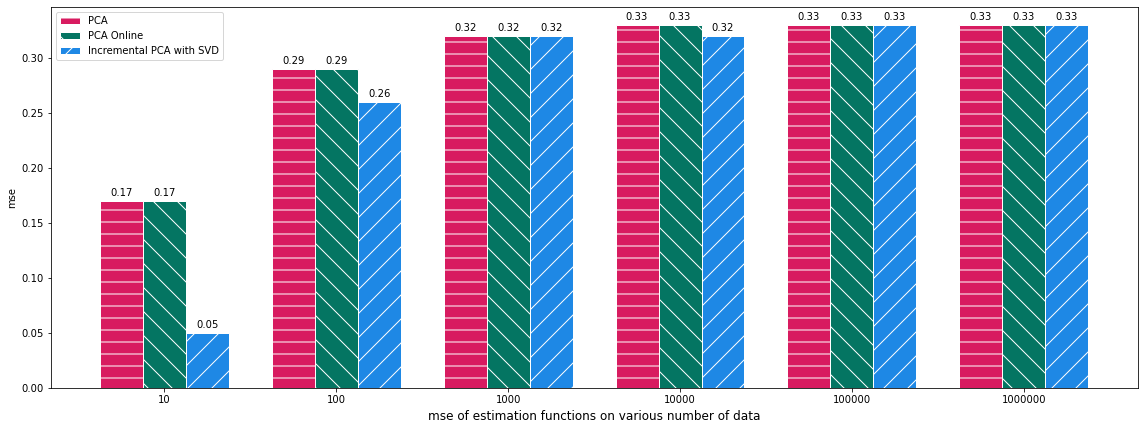

In [12]:
label = 'total_data'
title = 'mse of estimation functions on various number of data'
draw_bar_chart(df_synthetic1, label, title, metric='mse')

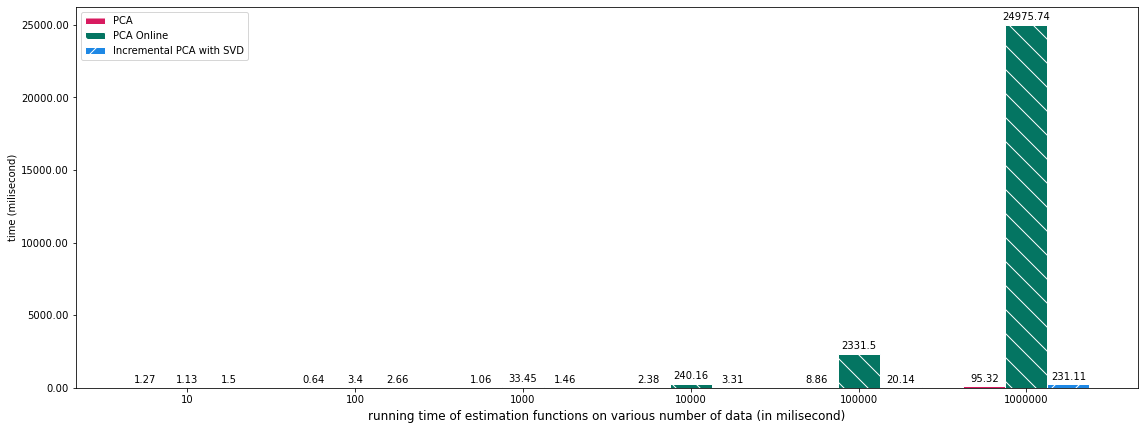

In [13]:
label = 'total_data'
title = 'running time of estimation functions on various number of data (in milisecond)'
metric = 'time'
draw_bar_chart(df_synthetic1, label, title, metric, timeunit='milisecond', figwidth=8, figheight=6,  
                   colors=('#D81B60', '#047562', '#1E88E5'), hatch=('-', '\\', '/'))

In [14]:
# metadata2 = ((10000, 10),
#              (10000, 50),
#              (10000, 100),
#              (10000, 250),
#              (10000, 500),
#              (10000, 1000),
# #              (10000, 5000),
#             )
# df_synthetic2 = build_experiment_synthetic_data(metadata2, variance_explained=0.9025)
# df_synthetic2.to_pickle('./estimation_synthetic2.pkl')
df_synthetic2 = pd.read_pickle('./estimation_synthetic2.pkl')
df_synthetic2.round(decimals=2)

,total_data,dimension,mse_pca,mse_pca_online,mse_inc_pca,time_pca,time_pca_online,time_inc_pca
0,10000,10,0.10,0.10,0.09,2.51,303.39,4.59
1,10000,50,0.02,0.02,0.02,12.50,500.53,18.58
2,10000,100,0.01,0.01,0.01,26.67,1081.87,46.46
3,10000,250,0.00,0.00,0.00,91.91,5885.23,147.41
4,10000,500,0.00,0.00,0.00,281.69,39891.15,688.14
5,10000,1000,0.00,0.00,0.00,1427.55,618650.25,4148.64


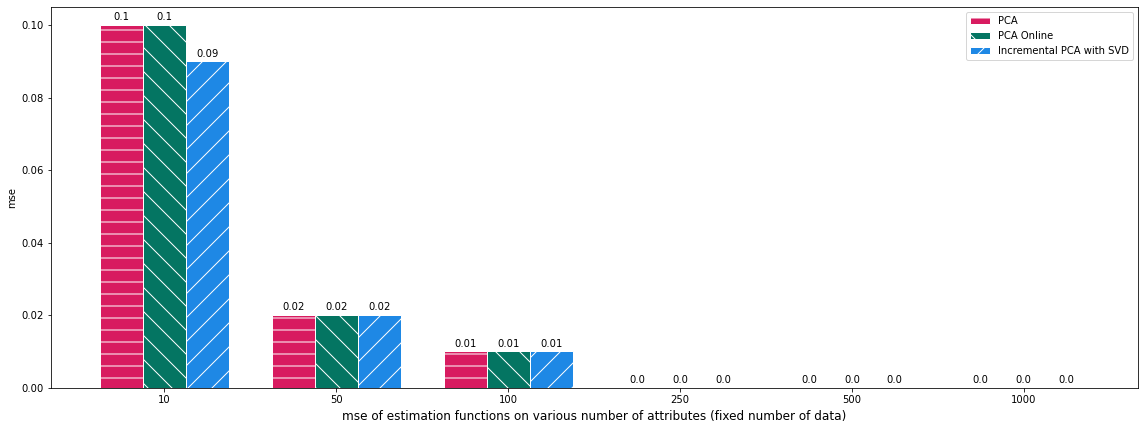

In [15]:
label = 'dimension'
title = 'mse of estimation functions on various number of attributes (fixed number of data)'
draw_bar_chart(df_synthetic2, label, title, metric='mse', figwidth=8, figheight=6,  
                   colors=('#D81B60', '#047562', '#1E88E5'), hatch=('-', '\\', '/'))

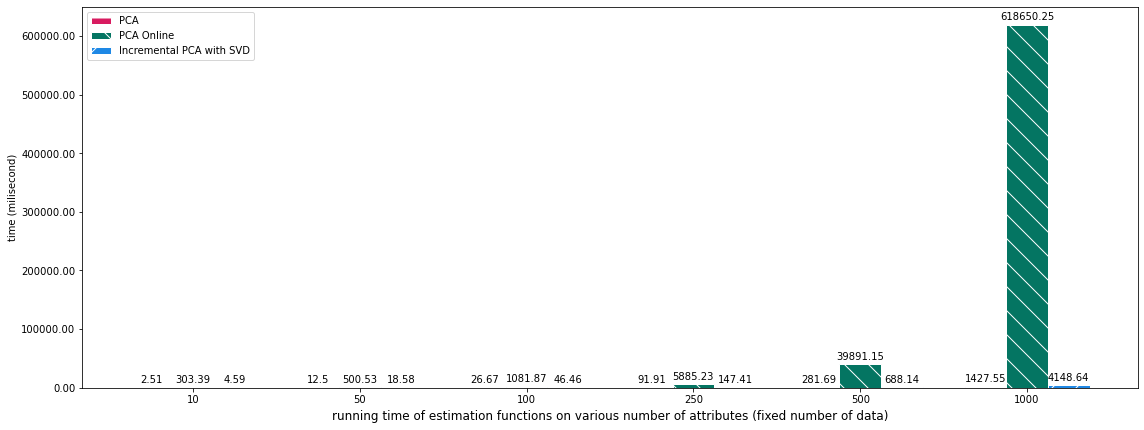

In [16]:
label = 'dimension'
title = 'running time of estimation functions on various number of attributes (fixed number of data)'
draw_bar_chart(df_synthetic2, label, title, metric='time', timeunit='milisecond', figwidth=8, figheight=6,  
                   colors=('#D81B60', '#047562', '#1E88E5'), hatch=('-', '\\', '/'))

## Test on outlier detection dataset

In [23]:
# filenames = ('../../data/xpacs/arrythmiadata.csv',
#              '../../data/xpacs/breastdata.csv',
#              '../../data/xpacs/digits2data.csv',
#              '../../data/xpacs/digitsdata.csv',
#              '../../data/xpacs/winedata.csv',
#              '../../data/xpacs/yeastdata.csv',
#              '../../data/forestcover/covtype.csv',
#              '../../data/kddcup1999/kddcup1999_10percent_number_only.csv'
#             )
# df = build_experiment_dataframe(filenames, variance_explained=0.9025)
# df.to_pickle('./estimation.pkl')
df = pd.read_pickle('./estimation_1.pkl')
df.round(decimals=2)

,dataset,total_data,dimension,mse_pca,mse_pca_online,mse_inc_pca,mse_spirit,time_pca,time_pca_online,time_inc_pca,time_spirit
0,arrythmiadata,332,172,0.0,0.0,0.0,0.01,63.67,410.81,33.13,685.81
1,breastdata,683,9,0.0,0.0,0.0,0.00,2.69,94.76,4.09,696.93
2,digits2data,1266,16,0.0,0.0,0.0,0.02,6.14,199.69,5.08,1232.73
3,digitsdata,1371,16,0.0,0.0,0.0,0.02,3.92,254.80,65.65,798.89
4,winedata,95,13,0.0,0.0,0.0,0.01,0.95,19.89,7.80,94.77
5,yeastdata,592,8,0.0,0.0,0.0,0.01,1.58,83.69,3.22,325.14
6,covtype,18000,55,0.0,0.0,0.0,87468.55,97.45,6012.34,159.91,15956.30
7,kddcup1999_10percent_number_only,18000,35,0.0,0.0,0.0,1245613.82,44.70,4329.54,85.85,14042.41


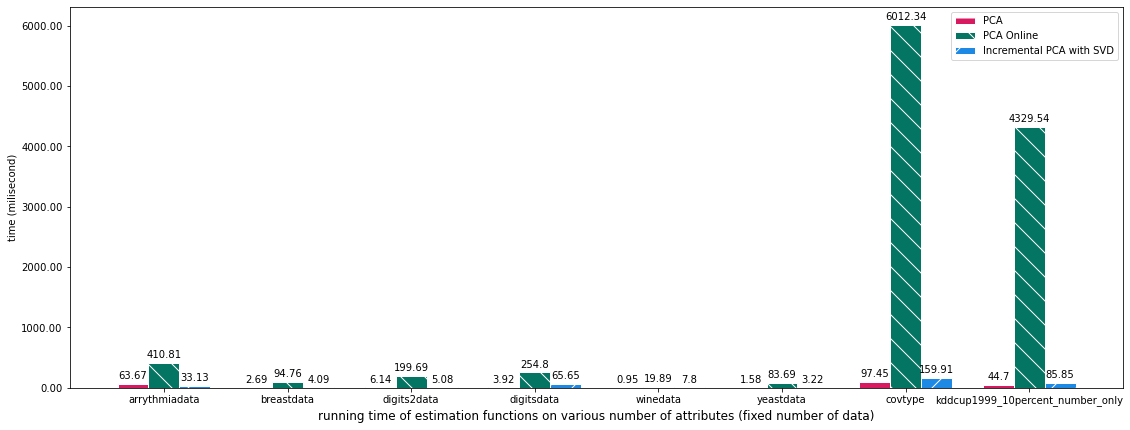

In [25]:
label = 'dataset'
title = 'running time of estimation functions on various number of attributes (fixed number of data)'
draw_bar_chart(df, label, title, metric='time', timeunit='milisecond', figwidth=8, figheight=6,  
                   colors=('#D81B60', '#047562', '#1E88E5'), hatch=('-', '\\', '/'))

Design the experiments, do it for every algorithm and then compare them
- Study the impact of the number of data points (the number of dimension fixed) --> draw the chart based on mse and running time
- Study the impact of the number of dimension (the number of data points fixed) --> 
- Consider the arrival rate

**SPIRIT run on matlab (fixed number of object's dimension):**

- 10, 3

Elapsed time is 0.039720 seconds.

- 100, 3

Elapsed time is 0.008207 seconds.

- 1000, 3

Elapsed time is 0.037102 seconds.

- 10000, 3

Elapsed time is 0.284534 seconds.

- 100000, 3

Elapsed time is 2.666182 seconds.

- 1000000, 3

Elapsed time is 31.647566 seconds.

**SPIRIT run on matlab (fixed number of objects):**

- (10000, 10)

Elapsed time is 0.387481 seconds.

- (10000, 50)

Elapsed time is 1.232846 seconds.

- (10000, 100)

Elapsed time is 2.717917 seconds.

- (10000, 250)

Elapsed time is 4.195774 seconds.

- (10000, 500)

Elapsed time is 7.815995 seconds.

- (10000, 1000)

Elapsed time is 16.669515 seconds.